In [170]:
import numpy as np
import math

In [171]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') 
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [172]:
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [173]:
h = 0.0001
a = 2
b = -3
c = 10
d1 = a*b + c
print('Nudging A')
print('d1', d1)
a = a+h
d2 = a*b + c
print('d2', d2)
print('slope', (d2-d1)/h)
print('\n')
print('Nudging B')
print('d1', d1)
b = b+h
d2 = a*b + c
print('d2', d2)
print('slope', (d2-d1)/h)
print('\n')
print('Nudging C')
print('d1', d1)
c = c+h
d2 = a*b + c
print('d2', d2)
print('slope', (d2-d1)/h)

Nudging A
d1 4
d2 3.999699999999999
slope -3.000000000010772


Nudging B
d1 4
d2 3.99990001
slope -0.9998999999982772


Nudging C
d1 4
d2 4.00000001
slope 9.99999993922529e-05


In [210]:
import math

class Value:
    def __init__(self, data, label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set()
        self._op = ''
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, label=f"({self.label}+{other.label})")
        out._prev = {self, other}
        out._op = '+'
        
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, label=f"({self.label}*{other.label})")
        out._prev = {self, other}
        out._op = '*'
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, label=f"tanh({self.label})")
        out._prev = {self}
        out._op = 'tanh'
        
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out


In [211]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label} | data={n.data:.4f} | grad={n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(n).render('graph', format='png')

'graph.png'

In [212]:
#inputs 
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights 
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
# #bias 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1*w1 + x2*w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label = 'o'


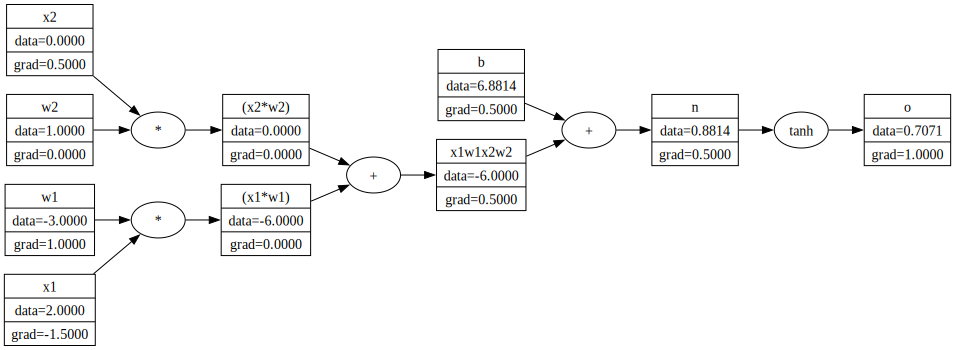

In [215]:
draw_dot(o)

In [214]:
#Manually doing Backward Propogation:

# o.grad = 1.0
# n.grad = 1 - o.data**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x1.grad = w1.data*x1w1.grad
# w1.grad = x1.data*x1w1.grad
# x2.grad = w2.data*x2w2.grad
# w2.grad = x2.data*x2w2.grad

In [216]:
#Doing Backward Prop using _backward() function
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()